# A quickstart guide

This guide shall run you through how to get your own trading strategy up and running, and backtested against some mocked data.

A trading node, in its current WIP state, consists of three key components:
1. `DataClient`: data provider, e.g. minute price data of a stock like AAPL
2. `Portfolio`: maintains state of trading portfolio
3. `Strategy`: the "engine" of the system which contains all business logic

## 1. Data Client

Every trading strategy requires data to base its decisions off. We use a publisher/subscriber architecture here. Essentially, the `DataClient` publishes data, and the `Strategy` instance subscribes to it. This is done via streaming data from the `DataClient` to `Strategy`.

Those who have taken CS2030S would recognise similarities between the event-driven system and the early labs, as well as the pub/sub system to Java `streams`.

To begin, we initialise an `aapl_data_client` which *publishes* a stream of minute data. Note that since we have not yet initialised a `Strategy` class, the data client has no subscribers.

In [1]:
from orbital.data.client import MockBarTickDataClient

aapl_data_client = MockBarTickDataClient(
    data_file_path='./orbital/data/mocked/AAPL.parquet',
    file_type='parquet',
    max_ticks=100000,
    symbol='aapl'
    )

We can view the first data point of the stream by calling the *private* function `_fetch_data`.

In [2]:
dp = aapl_data_client._fetch_data()
vars(dp)

{'timestamp': Timestamp('2007-04-27 10:43:00'),
 'symbol': 'aapl',
 'open': 98.41000366210938,
 'high': 98.45999908447266,
 'low': 98.30000305175781,
 'close': 98.30000305175781,
 'volume': 46196}

## 2. Portfolio

The `Portfolio` component tracks the current state of the portfolio. Here, we initialise it with starting cash and positions.

In [3]:
from orbital.portfolio.base import Portfolio

demo_portfolio = Portfolio(
    cash=1_000_000, # starting free cash
    positions=[] # start with empty positions
)

To get a better understanding of the portfolio, it is made up of `BasePosition` objects. Here, we artifically inject a `InstrumentPosition` into the portfolio.

In [4]:
from orbital.model.position import InstrumentPosition

temp_position = InstrumentPosition(
    symbol="AAPL",
    quantity=100,
    entry_price=100
)

demo_portfolio.update_position(temp_position)

demo_portfolio.to_dataframe()

,Symbol,Quantity,Entry Price,Created Time,Updated Time
0,AAPL,100,100,2023-07-23 18:30:17.332748,2023-07-23 18:30:17.332752


In [5]:
temp_position = InstrumentPosition(
    symbol="AAPL",
    quantity=100,
    entry_price=50
)

demo_portfolio.update_position(temp_position)

demo_portfolio.to_dataframe()

,Symbol,Quantity,Entry Price,Created Time,Updated Time
0,AAPL,200,75.0,2023-07-23 18:30:17.332748,2023-07-23 18:30:19.620227


In [6]:
temp_position = InstrumentPosition(
    symbol="AAPL",
    quantity=-200,
    entry_price=80
)

demo_portfolio.update_position(temp_position)
print(f'realised profit: {demo_portfolio.realised_profit}')
demo_portfolio.to_dataframe()

realised profit: 1000.0


,Symbol,Quantity,Entry Price,Created Time,Updated Time


We reset the portfolio before launching our strategy.

In [7]:
demo_portfolio = Portfolio(
    cash=1_000_000, # starting free cash
    positions=[], # start with empty positions
    history=[]
)

## 3. Strategy

The `Strategy` component serves as the "engine" to integrate with the data and portfolio components to process data to generate orders.

To begin, we've created a basic `DemoStrategy` which extends from the `BaseStrategy` class. At the moment, any custom `Strategy` must implement only the `handle_data` method.

The logic of the `DemoStrategy` is simple, for any instrument:
- if not in the portfolio, buy 100 shares of it
- if the market price is less than 90% of its price in the portfolio, buy
- if the market price is more than 110% of its price in the portfolio, sell

In [8]:
from orbital.strategy.demo import DemoStrategy

demo_strategy = DemoStrategy(portfolio=demo_portfolio)

We now subscribe our `demo_strategy` to the `aapl_data_client` so that our strategy has a data stream to base our logic off.

In [9]:
aapl_data_client.subscribe(demo_strategy)
aapl_data_client.subscribers

We now begin streaming data from the `aapl_data_client`. This also implicitly begins the simulation.

Note: we know this is bad practice and we will create a TradingNode class or similar to orchestrate this better. If you wish, you may refer to the design decisions log for more information.

In [10]:
aapl_data_client.start_streaming()

Streaming completed


Now that our simulation has ended, let's view some statistics.

In [11]:
demo_portfolio.to_dataframe() # end state of portfolio

,Symbol,Quantity,Entry Price,Created Time,Updated Time
0,aapl,3200,145.925626,2023-07-23 18:30:35.146246,2023-07-23 18:30:36.325527


In [12]:
demo_portfolio.statistics()

{'total_value': 714402.9907226562,
 'position_values': 425695.99609375,
 'free_cash': 288706.99462890625,
 'realised_profit': 27848.999786376953,
 'unrealised_profit': -41266.00799560547}

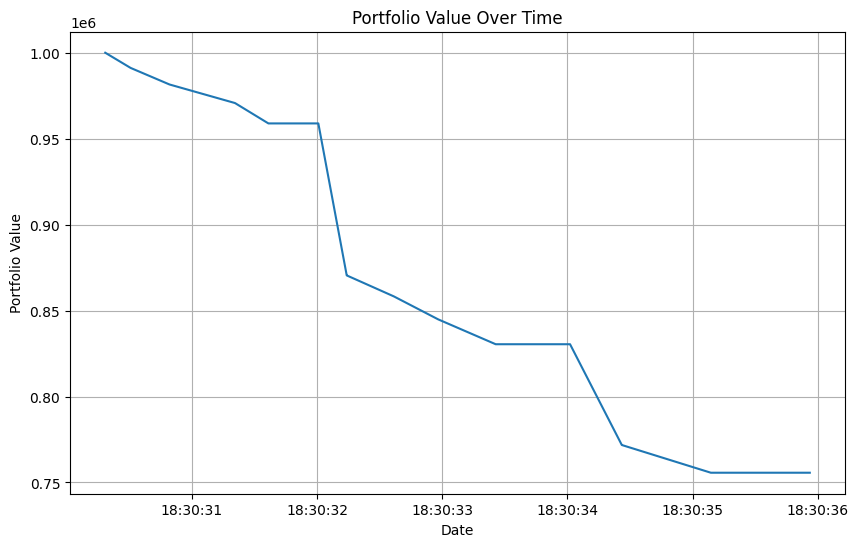

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = [{
    'value': state.value,
    'created_time': state.created_time
    } for state in demo_portfolio.history]

df = pd.DataFrame(data)

# Convert 'created_time' to datetime format if it isn't already
df['created_time'] = pd.to_datetime(df['created_time'])

plt.figure(figsize=(10, 6))  # This creates a new figure, and sets the size of the figure
sns.lineplot(data=df, x='created_time', y='value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

We are done!